In [1]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # minder spam, optioneel


import tensorflow as tf
tf.config.optimizer.set_jit(False)
from tensorflow.keras import layers, models
import json
import numpy as np
import pandas as pd

import datetime
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


DATASET_PATH = "resources/games/all_battles.json"
MODEL_EXPORT_PATH = "resources/models/"
SELECTED_PLAYERS = []
DISCOUNT_FACTOR = 0.98
EPOCHS = 20
BATCH_SIZE = 512
N_CORES = 8
LEARNING_RATE = 0.001

os.environ["OMP_NUM_THREADS"] = str(N_CORES)
os.environ["TF_NUM_INTRAOP_THREADS"] = str(N_CORES)
os.environ["TF_NUM_INTEROP_THREADS"] = str(N_CORES)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.20.0


In [2]:
def build_dataset(path):
    """
    CRITICAL FIX: Generate training data from BOTH players' perspectives.

    The key insight: In a two-player zero-sum game, we need to train the model
    to evaluate positions from a consistent perspective. We do this by:
    1. For each board position, create TWO training examples
    2. One from Light's perspective (original board, positive if Light wins)
    3. One from Dark's perspective (inverted board, positive if Dark wins)
    """
    with open(path) as f:
        data = json.load(f)

    print(f"Processing {len(data)} games")

    boards = []
    scores = []

    for game_idx, game in enumerate(data):
        # Skip games that don't have both players in the selected players list
        if SELECTED_PLAYERS and (
                game["lightPlayer"] not in SELECTED_PLAYERS or
                game["darkPlayer"] not in SELECTED_PLAYERS
        ):
            continue

        winner = game["winner"]  # 1 for Light, -1 for Dark
        n_moves = len(game["boardHistory"])
        reserve_size = game['reserveSize']

        for i, board_as_long in enumerate(game["boardHistory"]):
            # Convert board to array (0 = Light, 1 = Dark)
            board_as_array = np.array(
                [(board_as_long >> j) & 1 for j in range(59, -1, -1)],
                dtype=np.float32
            )

            # Calculate discount based on proximity to end of game
            # Positions closer to the end are more certain
            discount = DISCOUNT_FACTOR ** (n_moves - i - 1)

            # Light's perspective: positive if Light wins
            light_score = winner * discount * reserve_size
            boards.append(board_as_array)
            scores.append(light_score)

            # Dark's perspective: flip the board (0->1, 1->0) and score
            # This teaches the model to evaluate from the active player's view
            dark_board = 1.0 - board_as_array
            dark_score = -winner * discount * reserve_size  # Flip the score
            boards.append(dark_board)
            scores.append(dark_score)

        if game_idx % 1000 == 0:
            print(f"Processed game {game_idx}/{len(data)}")

    boards_array = np.array(boards, dtype=np.float32)
    scores_array = np.array(scores, dtype=np.float32)

    # Shuffle the dataset to mix Light and Dark perspectives
    indices = np.random.permutation(len(boards_array))

    return boards_array[indices], scores_array[indices]



In [3]:
def build_conv1d_model(
        filters1=32,
        filters2=64,
        kernel_size=3,
        dense_units1=64,
        dense_units2=32,
        dropout=0.3,
):
    """
    Conv1D-model dat de 60 velden als sequentie ziet: (60, 1)
    """
    inputs = layers.Input(shape=(60,), dtype=tf.float32)

    x = layers.Reshape((60, 1))(inputs)  # (batch, 60, 1)

    x = layers.Conv1D(filters1, kernel_size=kernel_size,
                      activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(filters2, kernel_size=kernel_size,
                      activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)

    x = layers.Dense(dense_units1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(dense_units2, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model



def build_conv2d_model(
        filters1,
        filters2,
        kernel_size,
        dense_units1,
        dense_units2,
        dropout,
):
    """
    Conv2D-model: we reshapen 60 -> (6, 10, 1).
    Dit is een beetje artificieel, maar laat je 2D-convs testen.
    """
    inputs = layers.Input(shape=(60,), dtype=tf.float32)

    x = layers.Reshape((6, 10, 1))(inputs)  # (batch, 6, 10, 1)

    x = layers.Conv2D(filters1, kernel_size=kernel_size,
                      activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters2, kernel_size=kernel_size,
                      activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(dense_units1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(dense_units2, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model



Dense modellen

In [4]:
def build_dense4_model(
        units1=256,
        units2=128,
        units3=64,
        units4=32,
        dropout1=0.3,
        dropout2=0.3,
        dropout3=0.2,
):

    inputs = layers.Input(shape=(60,), dtype=tf.float32)

    x = layers.Dense(units1, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout1)(x)

    x = layers.Dense(units2, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout2)(x)

    x = layers.Dense(units3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout3)(x)

    x = layers.Dense(units4, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model


def build_dense5_model(
        units1=256,
        units2=192,
        units3=128,
        units4=64,
        units5=32,
        dropout1=0.3,
        dropout2=0.3,
        dropout3=0.2,
        dropout4=0.2,
):
    """
    5-laags MLP voor als je echt diep wilt gaan.
    """
    inputs = layers.Input(shape=(60,), dtype=tf.float32)

    x = layers.Dense(units1, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout1)(x)

    x = layers.Dense(units2, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout2)(x)

    x = layers.Dense(units3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout3)(x)

    x = layers.Dense(units4, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout4)(x)

    x = layers.Dense(units5, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model
def build_dense6_model(
        units1=384, units2=256, units3=192, units4=128, units5=64, units6=32,
        dropout1=0.3, dropout2=0.3, dropout3=0.3, dropout4=0.2, dropout5=0.2,
):
    inputs = layers.Input(shape=(60,), dtype=tf.float32)

    x = layers.Dense(units1, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout1)(x)

    x = layers.Dense(units2, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout2)(x)

    x = layers.Dense(units3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout3)(x)

    x = layers.Dense(units4, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout4)(x)

    x = layers.Dense(units5, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout5)(x)

    x = layers.Dense(units6, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
def create_optimizer(name, learning_rate):
    name = name.lower()
    if name == "adam":
        return tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif name == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif name == "rmsprop":
        return tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer name: {name}")


In [6]:
def train_single_experiment(
        model_builder,
        model_kwargs,
        optimizer_name,
        learning_rate,
        batch_size,
        X_train, y_train,
        X_val, y_val,
        X_test, y_test,
        label,
        family,
):
    print(f"\n==== Running experiment: {label} ({family}) ====")

    model = model_builder(**model_kwargs)
    opt = create_optimizer(optimizer_name, learning_rate)

    model.compile(
        optimizer=opt,
        loss="mse",
        metrics=["mae"]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=2,
            min_lr=1e-6
        )
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0,
    )

    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

    best_val_loss = float(min(history.history["val_loss"]))
    best_val_mae = float(min(history.history["val_mae"]))

    print(f"Best val_loss: {best_val_loss:.4f}, best val_mae: {best_val_mae:.4f}")
    print(f"Test loss:     {test_loss:.4f}, test MAE:     {test_mae:.4f}")

    result = {
        "label": label,
        "family": family,
        "optimizer": optimizer_name,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "best_val_loss": best_val_loss,
        "best_val_mae": best_val_mae,
        "test_loss": test_loss,
        "test_mae": test_mae,
        "history": history.history,
    }
    return result


In [7]:
def generate_experiments():
    experiments = []

    """conv1d_archs = [
        {
            "name": "conv1d_small",
            "family": "conv1d",
            "builder": build_conv1d_model,
            "kwargs": dict(
                filters1=32, filters2=64,
                kernel_size=3,
                dense_units1=64, dense_units2=32,
                dropout=0.3,
            ),
        },
        {
            "name": "conv1d_medium",
            "family": "conv1d",
            "builder": build_conv1d_model,
            "kwargs": dict(
                filters1=64, filters2=128,
                kernel_size=5,
                dense_units1=128, dense_units2=64,
                dropout=0.4,
            ),
        },
        {
            "name": "conv1d_large",
            "family": "conv1d",
            "builder": build_conv1d_model,
            "kwargs": dict(
                filters1=96, filters2=192,
                kernel_size=5,
                dense_units1=128, dense_units2=64,
                dropout=0.4,
            ),
        },
    ]

    conv_optimizers = ["adam", "rmsprop", "sgd"]
    conv_lrs = [0.0005, 0.001]
    conv_batch_sizes = [256, 512]

    for arch in conv1d_archs:
        for opt in conv_optimizers:
            for lr in conv_lrs:
                for bs in conv_batch_sizes:
                    label = f"{arch['name']}_{opt}_lr{lr}_bs{bs}"
                    experiments.append({
                        "label": label,
                        "family": arch["family"],
                        "model_builder": arch["builder"],
                        "model_kwargs": arch["kwargs"],
                        "optimizer": opt,
                        "learning_rate": lr,
                        "batch_size": bs,
                    })

    """
    conv2d_archs = [
        {
            "name": "conv2d_small",
            "family": "conv2d",
            "builder": build_conv2d_model,
            "kwargs": dict(
                filters1=32, filters2=64,
                kernel_size=(3, 3),
                dense_units1=64, dense_units2=32,
                dropout=0.3,
            ),
        },
        {
            "name": "conv2d_medium",
            "family": "conv2d",
            "builder": build_conv2d_model,
            "kwargs": dict(
                filters1=64, filters2=128,
                kernel_size=(3, 3),
                dense_units1=128, dense_units2=64,
                dropout=0.3,
            ),
        },
    ]

    conv2_optimizers = ["adam", "rmsprop"]
    conv2_lrs = [0.0005, 0.001]
    conv2_batch_sizes = [256, 512]

    for arch in conv2d_archs:
        for opt in conv2_optimizers:
            for lr in conv2_lrs:
                for bs in conv2_batch_sizes:
                    label = f"{arch['name']}_{opt}_lr{lr}_bs{bs}"
                    experiments.append({
                        "label": label,
                        "family": arch["family"],
                        "model_builder": arch["builder"],
                        "model_kwargs": arch["kwargs"],
                        "optimizer": opt,
                        "learning_rate": lr,
                        "batch_size": bs,
                    })

 
    dense_archs = [
        # DENSE4
        {
            "name": "dense4_small",
            "family": "dense4",
            "builder": build_dense4_model,
            "kwargs": dict(
                units1=128, units2=64, units3=32, units4=16,
                dropout1=0.3, dropout2=0.3, dropout3=0.2,
            ),
        },
        {
            "name": "dense4_big",
            "family": "dense4",
            "builder": build_dense4_model,
            "kwargs": dict(
                units1=256, units2=128, units3=64, units4=32,
                dropout1=0.3, dropout2=0.3, dropout3=0.2,
            ),
        },
        # DENSE5
        {
            "name": "dense5_small",
            "family": "dense5",
            "builder": build_dense5_model,
            "kwargs": dict(
                units1=256, units2=192, units3=128, units4=64, units5=32,
                dropout1=0.3, dropout2=0.3, dropout3=0.2, dropout4=0.2,
            ),
        },
        {
            "name": "dense5_big",
            "family": "dense5",
            "builder": build_dense5_model,
            "kwargs": dict(
                units1=384, units2=256, units3=192, units4=96, units5=48,
                dropout1=0.3, dropout2=0.3, dropout3=0.2, dropout4=0.2,
            ),
        },
        # DENSE6
        {
            "name": "dense6_small",
            "family": "dense6",
            "builder": build_dense6_model,
            "kwargs": dict(
                units1=256, units2=192, units3=128, units4=96, units5=64, units6=32,
                dropout1=0.3, dropout2=0.3, dropout3=0.3, dropout4=0.2, dropout5=0.2,
            ),
        },
        {
            "name": "dense6_big",
            "family": "dense6",
            "builder": build_dense6_model,
            "kwargs": dict(
                units1=384, units2=256, units3=192, units4=128, units5=64, units6=32,
                dropout1=0.3, dropout2=0.3, dropout3=0.3, dropout4=0.2, dropout5=0.2,
            ),
        },
    ]

    dense_optimizers = ["adam", "rmsprop"]
    dense_lrs = [0.001]
    dense_batch_sizes = [256, 512]

    for arch in dense_archs:
        for opt in dense_optimizers:
            for lr in dense_lrs:
                for bs in dense_batch_sizes:
                    label = f"{arch['name']}_{opt}_lr{lr}_bs{bs}"
                    experiments.append({
                        "label": label,
                        "family": arch["family"],
                        "model_builder": arch["builder"],
                        "model_kwargs": arch["kwargs"],
                        "optimizer": opt,
                        "learning_rate": lr,
                        "batch_size": bs,
                    })

    print(f"Generated {len(experiments)} experiments.")
    return experiments


some helpers and plots

In [8]:
def select_top_by_family(results, family, metric="best_val_mae", top_n=3):
    family_results = [r for r in results if r["family"] == family]
    family_results_sorted = sorted(family_results, key=lambda r: r[metric])
    return family_results_sorted[:top_n]


plotting everything per fammily

In [9]:
def plot_family_histories(results, family, metric="mae", top_n=5):
    top_results = select_top_by_family(results, family, metric="best_val_mae", top_n=top_n)

    if not top_results:
        print(f"No results for family={family}")
        return

    plt.figure()
    for r in top_results:
        h = r["history"]
        label = r["label"]
        if metric in h:
            plt.plot(h[metric], linestyle="-", alpha=0.7, label=f"{label} (train)")
        val_key = f"val_{metric}"
        if val_key in h:
            plt.plot(h[val_key], linestyle="--", alpha=0.7, label=f"{label} (val)")

    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"{family} – top {top_n} by val MAE ({metric} per epoch)")
    plt.legend(fontsize=7)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


best inter familly

In [10]:
def plot_best_overall(results, metric="mae"):
    best_per_family = []
    families = sorted(set(r["family"] for r in results))
    for fam in families:
        top = select_top_by_family(results, fam, metric="best_val_mae", top_n=1)
        if top:
            best_per_family.append(top[0])

    if not best_per_family:
        print("No results to plot in best_overall.")
        return

    plt.figure()
    plt.savefig
    for r in best_per_family:
        h = r["history"]
        label = f"{r['family']} | {r['label']}"
        val_key = f"val_{metric}"
        if val_key in h:
            plt.plot(h[val_key], linestyle="-", label=label)

    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"Best model per family – validation {metric}")
    plt.legend(fontsize=7)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [11]:
def run_experiments(X_train, y_train, X_val, y_val, X_test, y_test):
    experiments = generate_experiments()
    print(f"Running {len(experiments)} experiments...\n")

    results = []

    for i, exp in enumerate(experiments):
        print(f"\n=== Experiment {i+1}/{len(experiments)}: {exp['label']} ===")
        res = train_single_experiment(
            model_builder=exp["model_builder"],
            model_kwargs=exp["model_kwargs"],
            optimizer_name=exp["optimizer"],
            learning_rate=exp["learning_rate"],
            batch_size=exp["batch_size"],
            X_train=X_train, y_train=y_train,
            X_val=X_val, y_val=y_val,
            X_test=X_test, y_test=y_test,
            label=exp["label"],
            family=exp["family"],
        )
        results.append(res)

    # DataFrame overzicht
    df = pd.DataFrame([
        {
            "label": r["label"],
            "family": r["family"],
            "optimizer": r["optimizer"],
            "lr": r["learning_rate"],
            "batch_size": r["batch_size"],
            "best_val_loss": r["best_val_loss"],
            "best_val_mae": r["best_val_mae"],
            "test_loss": r["test_loss"],
            "test_mae": r["test_mae"],
        }
        for r in results
    ])

    print("\n==================== RESULT TABLE (sorted by test MAE) ====================")
    print(df.sort_values("test_mae").head(20))

    # 1) conv1d verschillen
    plot_family_histories(results, family="conv1d", metric="mae", top_n=5)

    # 2) conv2d verschillen
    plot_family_histories(results, family="conv2d", metric="mae", top_n=5)

    # 3) dense4 / dense5 / dense6 verschillen
    plot_family_histories(results, family="dense4", metric="mae", top_n=5)
    plot_family_histories(results, family="dense5", metric="mae", top_n=5)
    plot_family_histories(results, family="dense6", metric="mae", top_n=5)

    # 4) beste per family tegen elkaar
    plot_best_overall(results, metric="mae")

    return results, df


TensorFlow version: 2.20.0
Loading dataset...
Processing 12000 games
Processed game 0/12000
Processed game 1000/12000
Processed game 2000/12000
Processed game 3000/12000
Processed game 4000/12000
Processed game 5000/12000
Processed game 6000/12000
Processed game 7000/12000
Processed game 8000/12000
Processed game 9000/12000
Processed game 10000/12000
Processed game 11000/12000
Train size: 581664
Val size:   145415
Test size:  181769
Generated 40 experiments.
Running 40 experiments...


=== Experiment 1/40: conv2d_small_adam_lr0.0005_bs256 ===

==== Running experiment: conv2d_small_adam_lr0.0005_bs256 (conv2d) ====


I0000 00:00:1763223930.539864     840 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1763223937.482985    1781 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Best val_loss: 1.5464, best val_mae: 0.9942
Test loss:     1.5474, test MAE:     0.9958

=== Experiment 2/40: conv2d_small_adam_lr0.0005_bs512 ===

==== Running experiment: conv2d_small_adam_lr0.0005_bs512 (conv2d) ====
Best val_loss: 1.5546, best val_mae: 0.9938
Test loss:     1.5617, test MAE:     0.9965

=== Experiment 3/40: conv2d_small_adam_lr0.001_bs256 ===

==== Running experiment: conv2d_small_adam_lr0.001_bs256 (conv2d) ====
Best val_loss: 1.5707, best val_mae: 1.0057
Test loss:     1.5784, test MAE:     1.0100

=== Experiment 4/40: conv2d_small_adam_lr0.001_bs512 ===

==== Running experiment: conv2d_small_adam_lr0.001_bs512 (conv2d) ====
Best val_loss: 1.5503, best val_mae: 0.9938
Test loss:     1.5505, test MAE:     0.9958

=== Experiment 5/40: conv2d_small_rmsprop_lr0.0005_bs256 ===

==== Running experiment: conv2d_small_rmsprop_lr0.0005_bs256 (conv2d) ====
Best val_loss: 1.5253, best val_mae: 0.9825
Test loss:     1.5328, test MAE:     0.9853

=== Experiment 6/40: conv2d_s

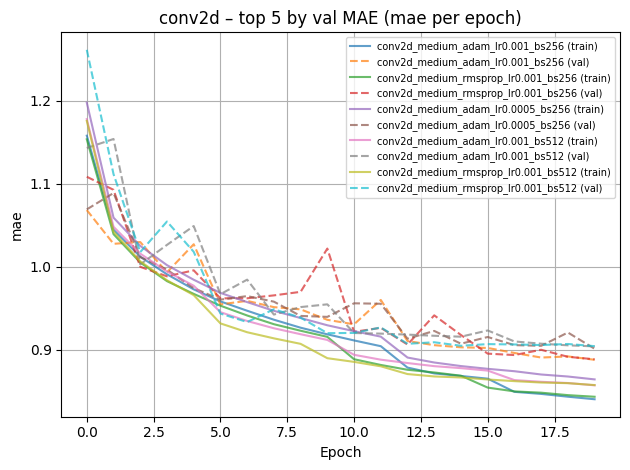

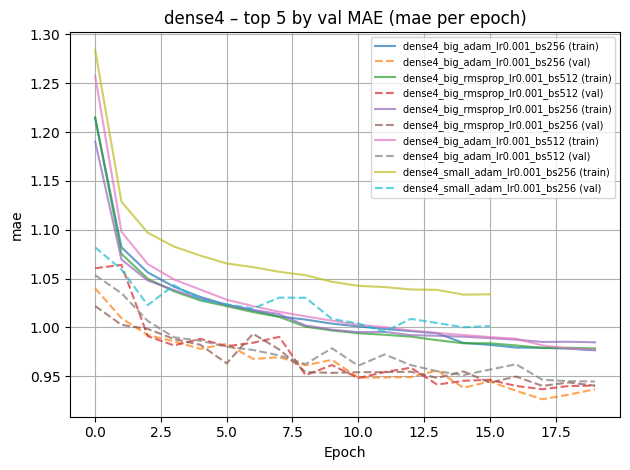

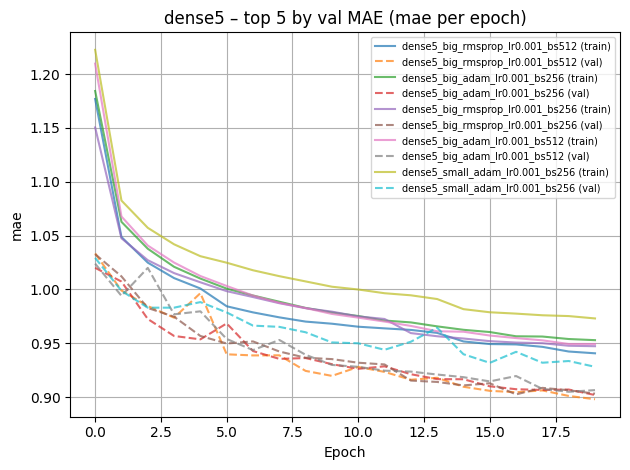

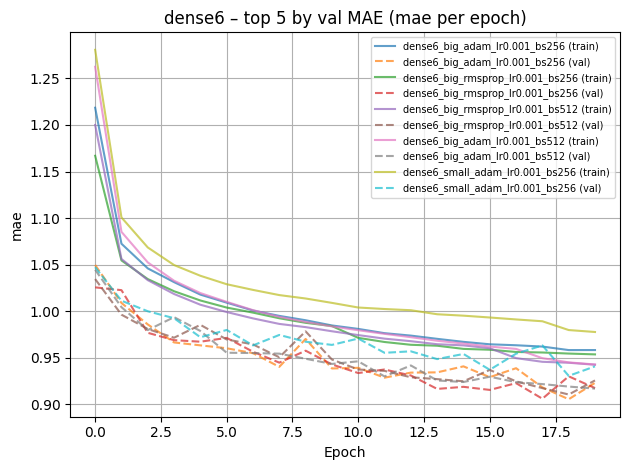

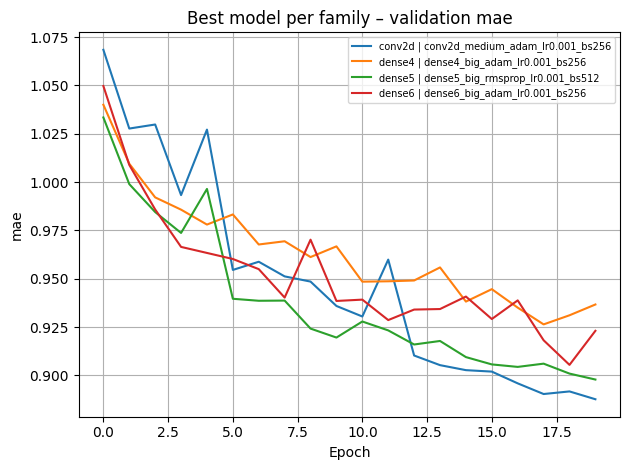


Best experiment based on test MAE:
label            conv2d_medium_rmsprop_lr0.001_bs256
family                                        conv2d
optimizer                                    rmsprop
lr                                             0.001
batch_size                                       256
best_val_loss                               1.291244
best_val_mae                                0.888301
test_loss                                    1.29408
test_mae                                     0.88952
Name: 14, dtype: object
                                   label  family optimizer      lr  \
0       conv2d_small_adam_lr0.0005_bs256  conv2d      adam  0.0005   
1       conv2d_small_adam_lr0.0005_bs512  conv2d      adam  0.0005   
2        conv2d_small_adam_lr0.001_bs256  conv2d      adam  0.0010   
3        conv2d_small_adam_lr0.001_bs512  conv2d      adam  0.0010   
4    conv2d_small_rmsprop_lr0.0005_bs256  conv2d   rmsprop  0.0005   
5    conv2d_small_rmsprop_lr0.0005_bs512  c

In [12]:
print("TensorFlow version:", tf.__version__)
print("Loading dataset...")

boards, scores = build_dataset(DATASET_PATH)

# ---- Train / Val / Test split ----
N = len(boards)
test_size = int(N * 0.2)
val_size  = int((N - test_size) * 0.2)

X_test = boards[:test_size]
y_test = scores[:test_size]

X_trainval = boards[test_size:]
y_trainval = scores[test_size:]

X_val = X_trainval[:val_size]
y_val = y_trainval[:val_size]

X_train = X_trainval[val_size:]
y_train = y_trainval[val_size:]

print(f"Train size: {len(X_train)}")
print(f"Val size:   {len(X_val)}")
print(f"Test size:  {len(X_test)}")

# hyperparameter search
results, df = run_experiments(X_train, y_train, X_val, y_val, X_test, y_test)

# eventueel: beste config tonen
best_row = df.sort_values("test_mae").iloc[0]
print("\nBest experiment based on test MAE:")
print(best_row)

print(df)
print (results)


Als train <<< val → overfitting
Als train ≈ val → goed model
Als train ≈ hoog en val ook hoog → underfitting

TensorFlow version: 2.20.0
Loading dataset...
Processing 12000 games
Processed game 0/12000
Processed game 1000/12000
Processed game 2000/12000
Processed game 3000/12000
Processed game 4000/12000
Processed game 5000/12000
Processed game 6000/12000
Processed game 7000/12000
Processed game 8000/12000
Processed game 9000/12000
Processed game 10000/12000
Processed game 11000/12000
Train size: 581664
Val size:   145415
Test size:  181769
Generated 76 experiments.
Running 76 experiments...


=== Experiment 1/76: conv1d_small_adam_lr0.0005_bs256 ===

==== Running experiment: conv1d_small_adam_lr0.0005_bs256 (conv1d) ====
WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1763148643.036242  386670 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1763148651.006328  387283 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Best val_loss: 1.3825, best val_mae: 0.9346
Test loss:     1.3814, test MAE:     0.9349

=== Experiment 2/76: conv1d_small_adam_lr0.0005_bs512 ===

==== Running experiment: conv1d_small_adam_lr0.0005_bs512 (conv1d) ====
Best val_loss: 1.3847, best val_mae: 0.9320
Test loss:     1.3821, test MAE:     0.9319

=== Experiment 3/76: conv1d_small_adam_lr0.001_bs256 ===

==== Running experiment: conv1d_small_adam_lr0.001_bs256 (conv1d) ====
Best val_loss: 1.3788, best val_mae: 0.9335
Test loss:     1.3759, test MAE:     0.9341

=== Experiment 4/76: conv1d_small_adam_lr0.001_bs512 ===

==== Running experiment: conv1d_small_adam_lr0.001_bs512 (conv1d) ====
Best val_loss: 1.3939, best val_mae: 0.9352
Test loss:     1.3912, test MAE:     0.9358

=== Experiment 5/76: conv1d_small_rmsprop_lr0.0005_bs256 ===

==== Running experiment: conv1d_small_rmsprop_lr0.0005_bs256 (conv1d) ====
Best val_loss: 1.3829, best val_mae: 0.9296
Test loss:     1.3795, test MAE:     0.9289

=== Experiment 6/76: conv1d_small_rmsprop_lr0.0005_bs512 ===

==== Running experiment: conv1d_small_rmsprop_lr0.0005_bs512 (conv1d) ====
Best val_loss: 1.3843, best val_mae: 0.9339
Test loss:     1.3849, test MAE:     0.9337

=== Experiment 7/76: conv1d_small_rmsprop_lr0.001_bs256 ===

==== Running experiment: conv1d_small_rmsprop_lr0.001_bs256 (conv1d) ====
Best val_loss: 1.3964, best val_mae: 0.9366
Test loss:     1.3964, test MAE:     0.9374

=== Experiment 8/76: conv1d_small_rmsprop_lr0.001_bs512 ===

==== Running experiment: conv1d_small_rmsprop_lr0.001_bs512 (conv1d) ====
Best val_loss: 1.3785, best val_mae: 0.9315
Test loss:     1.3766, test MAE:     0.9320

=== Experiment 9/76: conv1d_small_sgd_lr0.0005_bs256 ===

==== Running experiment: conv1d_small_sgd_lr0.0005_bs256 (conv1d) ====
Best val_loss: 1.4299, best val_mae: 0.9464
Test loss:     1.4270, test MAE:     0.9462

=== Experiment 10/76: conv1d_small_sgd_lr0.0005_bs512 ===

==== Running experiment: conv1d_small_sgd_lr0.0005_bs512 (conv1d) ====
Best val_loss: 1.4665, best val_mae: 0.9581
Test loss:     1.4655, test MAE:     0.9586

=== Experiment 11/76: conv1d_small_sgd_lr0.001_bs256 ===

==== Running experiment: conv1d_small_sgd_lr0.001_bs256 (conv1d) ====
Best val_loss: 1.4162, best val_mae: 0.9431
Test loss:     1.4148, test MAE:     0.9433

=== Experiment 12/76: conv1d_small_sgd_lr0.001_bs512 ===

==== Running experiment: conv1d_small_sgd_lr0.001_bs512 (conv1d) ====
Best val_loss: 1.4400, best val_mae: 0.9467
Test loss:     1.4400, test MAE:     0.9471

=== Experiment 13/76: conv1d_medium_adam_lr0.0005_bs256 ===

==== Running experiment: conv1d_medium_adam_lr0.0005_bs256 (conv1d) ====
Best val_loss: 1.1565, best val_mae: 0.8356
Test loss:     1.1524, test MAE:     0.8350

=== Experiment 14/76: conv1d_medium_adam_lr0.0005_bs512 ===

==== Running experiment: conv1d_medium_adam_lr0.0005_bs512 (conv1d) ====
Best val_loss: 1.1633, best val_mae: 0.8419
Test loss:     1.1624, test MAE:     0.8430

=== Experiment 15/76: conv1d_medium_adam_lr0.001_bs256 ===

==== Running experiment: conv1d_medium_adam_lr0.001_bs256 (conv1d) ====
Best val_loss: 1.1572, best val_mae: 0.8392
Test loss:     1.1548, test MAE:     0.8395

=== Experiment 16/76: conv1d_medium_adam_lr0.001_bs512 ===

==== Running experiment: conv1d_medium_adam_lr0.001_bs512 (conv1d) ====
Best val_loss: 1.1439, best val_mae: 0.8309
Test loss:     1.1429, test MAE:     0.8316

=== Experiment 17/76: conv1d_medium_rmsprop_lr0.0005_bs256 ===

==== Running experiment: conv1d_medium_rmsprop_lr0.0005_bs256 (conv1d) ====
Best val_loss: 1.1803, best val_mae: 0.8469
Test loss:     1.1823, test MAE:     0.8490

=== Experiment 18/76: conv1d_medium_rmsprop_lr0.0005_bs512 ===

==== Running experiment: conv1d_medium_rmsprop_lr0.0005_bs512 (conv1d) ====
Best val_loss: 1.1640, best val_mae: 0.8421
Test loss:     1.1640, test MAE:     0.8414

=== Experiment 19/76: conv1d_medium_rmsprop_lr0.001_bs256 ===

==== Running experiment: conv1d_medium_rmsprop_lr0.001_bs256 (conv1d) ====
Best val_loss: 1.1756, best val_mae: 0.8406
Test loss:     1.1758, test MAE:     0.8413

=== Experiment 20/76: conv1d_medium_rmsprop_lr0.001_bs512 ===

==== Running experiment: conv1d_medium_rmsprop_lr0.001_bs512 (conv1d) ====
Best val_loss: 1.1861, best val_mae: 0.8443
Test loss:     1.1861, test MAE:     0.8526

=== Experiment 21/76: conv1d_medium_sgd_lr0.0005_bs256 ===

==== Running experiment: conv1d_medium_sgd_lr0.0005_bs256 (conv1d) ====
Best val_loss: 1.3039, best val_mae: 0.8978
Test loss:     1.3033, test MAE:     0.8983

=== Experiment 22/76: conv1d_medium_sgd_lr0.0005_bs512 ===

==== Running experiment: conv1d_medium_sgd_lr0.0005_bs512 (conv1d) ====
Best val_loss: 1.3574, best val_mae: 0.9190
Test loss:     1.3541, test MAE:     0.9183

=== Experiment 23/76: conv1d_medium_sgd_lr0.001_bs256 ===

==== Running experiment: conv1d_medium_sgd_lr0.001_bs256 (conv1d) ====
Best val_loss: 1.2679, best val_mae: 0.8823
Test loss:     1.2653, test MAE:     0.8815

=== Experiment 24/76: conv1d_medium_sgd_lr0.001_bs512 ===

==== Running experiment: conv1d_medium_sgd_lr0.001_bs512 (conv1d) ====
Best val_loss: 1.3042, best val_mae: 0.8984
Test loss:     1.3026, test MAE:     0.9008

=== Experiment 25/76: conv1d_large_adam_lr0.0005_bs256 ===

==== Running experiment: conv1d_large_adam_lr0.0005_bs256 (conv1d) ====
Best val_loss: 1.1331, best val_mae: 0.8255
Test loss:     1.1312, test MAE:     0.8257

=== Experiment 26/76: conv1d_large_adam_lr0.0005_bs512 ===

==== Running experiment: conv1d_large_adam_lr0.0005_bs512 (conv1d) ====
Best val_loss: 1.1327, best val_mae: 0.8253
Test loss:     1.1302, test MAE:     0.8256

=== Experiment 27/76: conv1d_large_adam_lr0.001_bs256 ===

==== Running experiment: conv1d_large_adam_lr0.001_bs256 (conv1d) ====
Best val_loss: 1.1279, best val_mae: 0.8223
Test loss:     1.1252, test MAE:     0.8213

=== Experiment 28/76: conv1d_large_adam_lr0.001_bs512 ===

==== Running experiment: conv1d_large_adam_lr0.001_bs512 (conv1d) ====
Best val_loss: 1.1281, best val_mae: 0.8237
Test loss:     1.1314, test MAE:     0.8259

=== Experiment 29/76: conv1d_large_rmsprop_lr0.0005_bs256 ===

==== Running experiment: conv1d_large_rmsprop_lr0.0005_bs256 (conv1d) ====
Best val_loss: 1.1389, best val_mae: 0.8273
Test loss:     1.1381, test MAE:     0.8284

=== Experiment 30/76: conv1d_large_rmsprop_lr0.0005_bs512 ===

==== Running experiment: conv1d_large_rmsprop_lr0.0005_bs512 (conv1d) ====
Best val_loss: 1.1323, best val_mae: 0.8243
Test loss:     1.1319, test MAE:     0.8255

=== Experiment 31/76: conv1d_large_rmsprop_lr0.001_bs256 ===

==== Running experiment: conv1d_large_rmsprop_lr0.001_bs256 (conv1d) ====
Best val_loss: 1.1385, best val_mae: 0.8275
Test loss:     1.1378, test MAE:     0.8273

=== Experiment 32/76: conv1d_large_rmsprop_lr0.001_bs512 ===

==== Running experiment: conv1d_large_rmsprop_lr0.001_bs512 (conv1d) ====
Best val_loss: 1.1392, best val_mae: 0.8268
Test loss:     1.1384, test MAE:     0.8267

=== Experiment 33/76: conv1d_large_sgd_lr0.0005_bs256 ===

==== Running experiment: conv1d_large_sgd_lr0.0005_bs256 (conv1d) ====
Best val_loss: 1.2843, best val_mae: 0.8905
Test loss:     1.2852, test MAE:     0.8924

=== Experiment 34/76: conv1d_large_sgd_lr0.0005_bs512 ===

==== Running experiment: conv1d_large_sgd_lr0.0005_bs512 (conv1d) ====
Best val_loss: 1.3358, best val_mae: 0.9097
Test loss:     1.3287, test MAE:     0.9081

=== Experiment 35/76: conv1d_large_sgd_lr0.001_bs256 ===

==== Running experiment: conv1d_large_sgd_lr0.001_bs256 (conv1d) ====
Best val_loss: 1.2512, best val_mae: 0.8787
Test loss:     1.2475, test MAE:     0.8783

=== Experiment 36/76: conv1d_large_sgd_lr0.001_bs512 ===

==== Running experiment: conv1d_large_sgd_lr0.001_bs512 (conv1d) ====
Best val_loss: 1.2867, best val_mae: 0.8884
Test loss:     1.2827, test MAE:     0.8876

=== Experiment 37/76: conv2d_small_adam_lr0.0005_bs256 ===

==== Running experiment: conv2d_small_adam_lr0.0005_bs256 (conv2d) ====
Best val_loss: 1.5474, best val_mae: 0.9946
Test loss:     1.5485, test MAE:     0.9962

=== Experiment 38/76: conv2d_small_adam_lr0.0005_bs512 ===

==== Running experiment: conv2d_small_adam_lr0.0005_bs512 (conv2d) ====
Best val_loss: 1.5595, best val_mae: 0.9994
Test loss:     1.5646, test MAE:     1.0001

=== Experiment 39/76: conv2d_small_adam_lr0.001_bs256 ===

==== Running experiment: conv2d_small_adam_lr0.001_bs256 (conv2d) ====
Best val_loss: 1.5450, best val_mae: 0.9980
Test loss:     1.5445, test MAE:     0.9973

=== Experiment 40/76: conv2d_small_adam_lr0.001_bs512 ===

==== Running experiment: conv2d_small_adam_lr0.001_bs512 (conv2d) ====
Best val_loss: 1.5497, best val_mae: 0.9985
Test loss:     1.5574, test MAE:     1.0004

=== Experiment 41/76: conv2d_small_rmsprop_lr0.0005_bs256 ===

==== Running experiment: conv2d_small_rmsprop_lr0.0005_bs256 (conv2d) ====
Best val_loss: 1.5352, best val_mae: 0.9891
Test loss:     1.5387, test MAE:     0.9893

=== Experiment 42/76: conv2d_small_rmsprop_lr0.0005_bs512 ===

==== Running experiment: conv2d_small_rmsprop_lr0.0005_bs512 (conv2d) ====
Best val_loss: 1.5687, best val_mae: 1.0024
Test loss:     1.5719, test MAE:     1.0028

=== Experiment 43/76: conv2d_small_rmsprop_lr0.001_bs256 ===

==== Running experiment: conv2d_small_rmsprop_lr0.001_bs256 (conv2d) ====
Best val_loss: 1.5100, best val_mae: 0.9841
Test loss:     1.5170, test MAE:     0.9858

=== Experiment 44/76: conv2d_small_rmsprop_lr0.001_bs512 ===

==== Running experiment: conv2d_small_rmsprop_lr0.001_bs512 (conv2d) ====
Best val_loss: 1.7247, best val_mae: 1.0485
Test loss:     1.7268, test MAE:     1.0551

=== Experiment 45/76: conv2d_medium_adam_lr0.0005_bs256 ===

==== Running experiment: conv2d_medium_adam_lr0.0005_bs256 (conv2d) ====
Best val_loss: 1.3593, best val_mae: 0.9204
Test loss:     1.3634, test MAE:     0.9198

=== Experiment 46/76: conv2d_medium_adam_lr0.0005_bs512 ===

==== Running experiment: conv2d_medium_adam_lr0.0005_bs512 (conv2d) ====
Best val_loss: 1.3386, best val_mae: 0.9105
Test loss:     1.3401, test MAE:     0.9110

=== Experiment 47/76: conv2d_medium_adam_lr0.001_bs256 ===

==== Running experiment: conv2d_medium_adam_lr0.001_bs256 (conv2d) ====
Best val_loss: 1.3031, best val_mae: 0.8960
Test loss:     1.3117, test MAE:     0.8979

=== Experiment 48/76: conv2d_medium_adam_lr0.001_bs512 ===

==== Running experiment: conv2d_medium_adam_lr0.001_bs512 (conv2d) ====
Best val_loss: 1.3079, best val_mae: 0.8983
Test loss:     1.3181, test MAE:     0.9012

=== Experiment 49/76: conv2d_medium_rmsprop_lr0.0005_bs256 ===

==== Running experiment: conv2d_medium_rmsprop_lr0.0005_bs256 (conv2d) ====
Best val_loss: 1.3225, best val_mae: 0.9052
Test loss:     1.3203, test MAE:     0.9043

=== Experiment 50/76: conv2d_medium_rmsprop_lr0.0005_bs512 ===

==== Running experiment: conv2d_medium_rmsprop_lr0.0005_bs512 (conv2d) ====
Best val_loss: 1.3515, best val_mae: 0.9145
Test loss:     1.3553, test MAE:     0.9197

=== Experiment 51/76: conv2d_medium_rmsprop_lr0.001_bs256 ===

==== Running experiment: conv2d_medium_rmsprop_lr0.001_bs256 (conv2d) ====
Best val_loss: 1.2902, best val_mae: 0.8903
Test loss:     1.2904, test MAE:     0.8898

=== Experiment 52/76: conv2d_medium_rmsprop_lr0.001_bs512 ===

==== Running experiment: conv2d_medium_rmsprop_lr0.001_bs512 (conv2d) ====